<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Utilities" data-toc-modified-id="Utilities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Basic" data-toc-modified-id="Basic-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Basic</a></span></li><li><span><a href="#ViewPooling" data-toc-modified-id="ViewPooling-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>ViewPooling</a></span></li></ul></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Experiments" data-toc-modified-id="Experiments-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Experiments</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#MultiDepth-(LEAP)" data-toc-modified-id="MultiDepth-(LEAP)-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>MultiDepth (LEAP)</a></span></li><li><span><a href="#MultiDepthViewPooling" data-toc-modified-id="MultiDepthViewPooling-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>MultiDepthViewPooling</a></span></li></ul></li></ul></li></ul></div>

In [84]:
#%env CUDA_VISIBLE_DEVICES=2,3
import setGPU
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image

from sklearn.metrics import confusion_matrix
import pandas as pd
import time
import math
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision.models import vgg16

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [85]:
from JupyterLoader import NotebookFinder
import sys
sys.meta_path.append(NotebookFinder())

# Utilities

In [86]:
from utilities import AverageMeter, accuracy, get_trainable_parameters, varify

In [87]:
from dataloaders.Berlino_dataloader import get_loaders
batch_size = 8
num_workers = 4
loaders, display, vocab = get_loaders(folder='/home/frati/',
                               split = (0.3,0.5), # 70% train 15% valid 15% test 
                               dataset='full',
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=num_workers,
                               seed = 5)

In [88]:
partitions = ['train','valid','test']
for part in partitions:
    print(part,len(loaders[part]))

train 377
valid 81
test 81


In [89]:
#views, labels, labels_lengths, objects  = next(iter(loaders['train']))

# Models

In [90]:
from models.colorNet import ColorNet

from models.Ensembler import Ensembler
from models.viewPooler import ViewPooler

from models.partialVGG import get_partialVGG

In [91]:
models = {}
learning_rate = 0.001
gamma = 0.1
#scheduler
step_size=1

### Basic

In [9]:
partial_vgg, partial_features = get_partialVGG(30)

counter = 0
for param in partial_vgg.parameters(): # freeze vgg
    if counter < 20:
        param.requires_grad = False
    counter += 1

#basic_features_extractor = nn.Sequential( ColorNet(triplegrey=True),
#                                          partial_vgg)

fc_ensemble_model = Ensembler( features_extractor = partial_vgg,
                               in_features=partial_features,
                               out_features=25,
                               views = 4)
fc_ensemble_model.cuda()

fc_ensemble_trainable_params = get_trainable_parameters(fc_ensemble_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_ensemble_trainable_params, lr=learning_rate, weight_decay = 0.2)
#optimizer = torch.optim.SGD(fc_ensemble_trainable_params, lr=learning_rate, weight_decay = 0.2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

models['Basic'] = {
    'model': fc_ensemble_model,
    'criterion': criterion,
    'optimizer': optimizer,
    'scheduler': scheduler
}

fc_ensemble_model

Trainable parameters:	     9590849
Frozen parameters:	     7635264


Ensembler(
  (features_extractor): partialVGG(
    (features): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPo

### ViewPooling

In [10]:
partial_vgg, partial_features = get_partialVGG(30) # second last MaxPool

counter = 0
for param in partial_vgg.parameters(): # freeze vgg except the last convolutional layer
    if counter < 20:
        param.requires_grad = False
    counter += 1

#basic_features_extractor = nn.Sequential( ColorNet(triplegrey=True),
#                                          partial_vgg)

viewpool_model = ViewPooler( in_features=partial_features,
                             out_features=25,
                             features_extractor=partial_vgg, 
                             views=4)
viewpool_model.cuda()

viewpool_trainable_params = get_trainable_parameters(viewpool_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(viewpool_trainable_params, lr=learning_rate, weight_decay = 0.2)
#optimizer = torch.optim.SGD(viewpool_trainable_params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

models['ViewPool'] = {
    'model': viewpool_model,
    'criterion': criterion,
    'optimizer': optimizer,
    'scheduler': scheduler
}

viewpool_model

Trainable parameters:	     9641025
Frozen parameters:	     7635264


ViewPooler(
  (features_extractor): partialVGG(
    (features): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxP

# Training

In [11]:
def train_object_recognition( model_name, model, dataloaders, gpu_id=0, num_epochs=2, num_objects=25):
    
    model['model'].cuda(gpu_id)
    
    since = time.time()

    best_model_wts = model['model'].state_dict()
    best_acc = 0.0
    best_epoch = 0

    
    model['log']={
        'train': {'acc':[],
                  'loss':[], 
                  'obj_acc': [(0,0)]*25,
                  'epoch_acc':[],
                  'epoch_loss':[],
                  'confusion':[]},
        'valid': {'acc':[],
                  'loss':[], 
                  'obj_acc': [(0,0)]*25,
                  'epoch_acc':[],
                  'epoch_loss':[],
                  'confusion':[]}
    }
    
    log = model['log']
    
    dataset_sizes = {key:len(val.dataset) for key,val in dataloaders.items()}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model['scheduler'].step()
                model['model'].train() # Set model to training mode
                volatile_inputs = False
            else:
                model['model'].eval() # Set model to evaluate mode
                volatile_inputs = True

            running_loss = 0.0
            running_acc = 0
            log_entry_acc = []
            log_entry_loss = []
            confusion = np.zeros((num_objects,num_objects),dtype='int64')
            
            batches = len(dataloaders[phase])
            # Iterate over data.
            for idx,(data) in enumerate(dataloaders[phase]):
                # get the inputs
                views, labels, lenghts, targets = data
                
                
                # Set mini-batch dataset
                inputs = varify(x=views,gpu_id=gpu_id, volatile=volatile_inputs)
                inputs = [torch.cat([x,x,x], dim=1)for x in inputs]
                ground_truth = varify(x=targets,gpu_id=gpu_id,volatile=volatile_inputs)
                
                # zero the parameter gradients
                model['optimizer'].zero_grad()
                
                # forward
                outputs = model['model'](inputs)
                
                loss = model['criterion'](outputs, ground_truth)

                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                        
                    #optimizer.step()
                    model['optimizer'].step()
                    
                
                # compute and log accuracy
                _, preds = torch.max(outputs,1)
                correct = float(torch.sum(preds == ground_truth))
                acc = correct/len(preds)
    
                # statistics
                running_loss += loss.data[0]
                log_entry_acc.append(acc)
                log_entry_loss.append(loss.data[0])
                running_acc += correct
                
                # log predictions and ground_truth to compute confuion
                #log[phase]['confusion'].extend(list(zip(preds.detach().cpu().numpy(),ground_truth.detach().cpu().numpy())))
                confusion += confusion_matrix(y_true = ground_truth.data.cpu(),
                                              y_pred = preds.data.cpu().numpy(), 
                                              labels = list(range(num_objects)))
                
                
                # progress
                print("\r                                                                                        ",end="")
                #print("\r{}: {}/{} - acc: {:.2f} - loss: {:.2f}".format(phase,idx,batches,sv_acc,sv_avg_loss),end="")
                print("\r{} {}: {:>5}/{:<5} [ acc: {:.2f} - loss: {:.2f} ]".format(phase,model_name, idx,batches,acc,loss.data[0]),end="")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_acc / dataset_sizes[phase]
            log[phase]['acc'].append(log_entry_acc)
            log[phase]['loss'].append(log_entry_loss)
            log[phase]['epoch_acc'].append(epoch_acc)
            log[phase]['epoch_loss'].append(epoch_loss)
            log[phase]['confusion'].append(confusion)

            print()
            print('{} {} loss: {:.4f} acc: {:.4f}'.format(phase, model_name, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = model['model'].state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation acc: {:4f}'.format(best_acc))

    # load best model weights
    model['model'].load_state_dict(best_model_wts)
    model['best_acc'] = best_acc
    model['log']['valid']['best_epoch'] = best_epoch

In [12]:
models.keys()

dict_keys(['Basic', 'ViewPool'])

In [13]:
#models['MultiDepth']['model'].features_extractor[0] == models['MDVP']['model'].features_extractor[0]

In [14]:
train_object_recognition(model_name='ViewPool', 
                             model=models['ViewPool'],
                             dataloaders=loaders,
                             num_epochs=7,
                             num_objects=25)

Epoch 1/7
----------
train ViewPool:   376/377   [ acc: 1.00 - loss: 0.51 ]                                  
train ViewPool loss: 0.1253 acc: 0.7430
valid ViewPool:    80/81    [ acc: 0.33 - loss: 2.34 ]                                  
valid ViewPool loss: 0.3056 acc: 0.2895

Epoch 2/7
----------
train ViewPool:   376/377   [ acc: 1.00 - loss: 0.88 ]                                  
train ViewPool loss: 0.0587 acc: 0.9519
valid ViewPool:    80/81    [ acc: 1.00 - loss: 0.97 ]                                  
valid ViewPool loss: 0.1380 acc: 0.9954

Epoch 3/7
----------
train ViewPool:   376/377   [ acc: 0.75 - loss: 0.89 ]                                  
train ViewPool loss: 0.0553 acc: 0.9714
valid ViewPool:    80/81    [ acc: 1.00 - loss: 0.29 ]                                  
valid ViewPool loss: 0.0330 acc: 0.9969

Epoch 4/7
----------
train ViewPool:   376/377   [ acc: 1.00 - loss: 0.74 ]                                  
train ViewPool loss: 0.0532 acc: 0.9781
valid View

In [20]:
for model_name in models:
    train_object_recognition(model_name=model_name, 
                             model=models[model_name],
                             dataloaders=loaders,
                             num_epochs=7,
                             num_objects=25)
    torch.cuda.empty_cache()

Epoch 1/7
----------
train Basic:   376/377   [ acc: 1.00 - loss: 0.36 ]                                     
train Basic loss: 0.2332 acc: 0.5647
valid Basic:    80/81    [ acc: 1.00 - loss: 0.14 ]                                     
valid Basic loss: 0.0651 acc: 0.9272

Epoch 2/7
----------
train Basic:   376/377   [ acc: 1.00 - loss: 0.17 ]                                     
train Basic loss: 0.0528 acc: 0.9685
valid Basic:    80/81    [ acc: 1.00 - loss: 0.15 ]                                     
valid Basic loss: 0.0514 acc: 0.9706

Epoch 3/7
----------
train Basic:   376/377   [ acc: 1.00 - loss: 0.31 ]                                     
train Basic loss: 0.0460 acc: 0.9784
valid Basic:    80/81    [ acc: 1.00 - loss: 0.46 ]                                     
valid Basic loss: 0.0495 acc: 0.9706

Epoch 4/7
----------
train Basic:   376/377   [ acc: 0.75 - loss: 0.73 ]                                     
train Basic loss: 0.0458 acc: 0.9814
valid Basic:    80/81    [ acc:

In [16]:
def test_object_recognition( model_name, model, dataloaders, num_objects=25):
    
    since = time.time()
    
    log={ 'acc':[],
          'loss':[], 
          'obj_acc': [(0,0)]*25,
          'epoch_acc':[],
          'epoch_loss':[],
          'confusion':[]
        }
    
    phase = 'test'
    
    dataset_sizes = {key:len(val.dataset) for key,val in dataloaders.items()}
        
    model['model'].eval() # Set model to evaluate mode
    volatile_inputs = True

    running_loss = 0.0
    running_acc = 0
    log_entry_acc = []
    log_entry_loss = []
    confusion = np.zeros((num_objects,num_objects),dtype='int64')

    batches = len(dataloaders[phase])
    # Iterate over data.
    for idx,(data) in enumerate(dataloaders[phase]):
        # get the inputs
        views, labels, lenghts, targets = data


        # Set mini-batch dataset
        inputs = varify(x=views,gpu_id=0, volatile=volatile_inputs)
        inputs = [torch.cat([x,x,x], dim=1)for x in inputs]
        ground_truth = varify(x=targets,gpu_id=0,volatile=volatile_inputs)

        # forward
        outputs = model['model'](inputs)

        loss = model['criterion'](outputs, ground_truth)


        # compute and log accuracy
        _, preds = torch.max(outputs,1)
        correct = float(torch.sum(preds == ground_truth))
        acc = correct/len(preds)

        # statistics
        running_loss += loss.data[0]
        log_entry_acc.append(acc)
        log_entry_loss.append(loss.data[0])
        running_acc += correct

        # log predictions and ground_truth to compute confuion
        #log[phase]['confusion'].extend(list(zip(preds.detach().cpu().numpy(),ground_truth.detach().cpu().numpy())))
        confusion += confusion_matrix(y_true = ground_truth.data.cpu(),
                                      y_pred = preds.data.cpu().numpy(), 
                                      labels = list(range(num_objects)))


        # progress
        print("\r                                                                                        ",end="")
        #print("\r{}: {}/{} - acc: {:.2f} - loss: {:.2f}".format(phase,idx,batches,sv_acc,sv_avg_loss),end="")
        print("\r{} {}: {:>5}/{:<5} [ acc: {:.2f} - loss: {:.2f} ]".format(phase,model_name, idx,batches,acc,loss.data[0]),end="")

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_acc / dataset_sizes[phase]
    #log['acc'].append(log_entry_acc)
    #log['loss'].append(log_entry_loss)
    #log['epoch_acc'].append(epoch_acc)
    #log['epoch_loss'].append(epoch_loss)
    #log['confusion'].append(confusion)

    print()
    print('{} {} loss: {:.4f} acc: {:.4f}'.format(phase, model_name, epoch_loss, epoch_acc))

    print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [22]:
for model_name in models:
    test_object_recognition( model_name=model_name, 
                             model=models[model_name],
                             dataloaders=loaders,
                             num_objects=25)

test Basic:    80/81    [ acc: 1.00 - loss: 0.27 ]                                      
test Basic loss: 0.0448 acc: 0.9767

Testing complete in 0m 9s
test ViewPool:    80/81    [ acc: 1.00 - loss: 0.21 ]                                   
test ViewPool loss: 0.0256 acc: 0.9969

Testing complete in 0m 9s


In [17]:
test_object_recognition( model_name="ViewPool", 
                         model=models["ViewPool"],
                         dataloaders=loaders,
                         num_objects=25)

test ViewPool:    80/81    [ acc: 1.00 - loss: 0.24 ]                                   
test ViewPool loss: 0.0275 acc: 0.9907

Testing complete in 0m 9s


In [18]:
#torch.save(models['Basic']['model'].state_dict(),'triple_features_model_best-Basic-97test-seed5.pth.tar')
torch.save(models['ViewPool']['model'].state_dict(),'new_triple_features_model_best-ViewPool-99test-seed5.pth.tar')

In [81]:
class Pooler(nn.Module):
    def __init__(self, in_features, out_features, features_extractor, views):
        super(Pooler, self).__init__()
        self.features_extractor = features_extractor
        self.view_pooling = nn.MaxPool2d(kernel_size=(views,1))
        self.classifier = nn.Sequential(nn.BatchNorm1d(in_features, momentum=0.01),
                                        nn.Linear(in_features, 100),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.2),
                                        nn.Linear(100,out_features))

    def forward(self, views):
        views_features = [self.features_extractor(view) for view in views]
        
        ims,filters,h,w = views_features[0].shape
        
        flat_views = [view.view(ims,-1) for view in views_features]
        stacked_views = torch.stack(flat_views,dim=1)
        pooled_views = self.view_pooling(stacked_views).squeeze()
        
        preds = self.classifier(pooled_views)
        
        return preds

In [83]:
pool = Pooler(512*7*7,25,partial_vgg,4)
pool

Pooler(
  (features_extractor): partialVGG(
    (features): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2

In [23]:
views, labels, labels_lengths, objects  = next(iter(loaders['train']))

In [21]:
test_model = ViewPooler( in_features=partial_features,
                         out_features=25,
                         features_extractor=partial_vgg, 
                         views=4,
                         intermediate=True)
test_model.load_state_dict(models['ViewPool']['model'].state_dict())
test_model.cuda()

ViewPooler(
  (features_extractor): partialVGG(
    (features): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxP

In [57]:
objs = {}
for i in range(25):
    objs[i] = []
    
feat = {}
for i in range(25):
    feat[i] = []
    
for idx,(data) in enumerate(loaders['test']):
    # get the inputs
    print("\r{}".format(idx),end="")
    views, labels, lenghts, targets = data
    views = [torch.cat([x,x,x], dim=1)for x in varify(views)]
    features = test_model(views)
    objects = models['ViewPool']['model'](views)
    for idx,targ in enumerate(targets):
        objs[targ].append(objects[idx].data.cpu().numpy())
        feat[targ].append(features[idx].data.cpu().numpy())
    

80

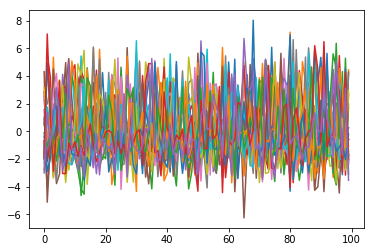

In [76]:
for key,val in feat.items():
    plt.plot(np.array(val).mean(axis=0))

# Results

In [21]:
def plot_confusion(model_name, models):

    epoch = models[model_name]['log']['valid']['best_epoch']
    cm = models[model_name]['log']['valid']['confusion'][epoch]
    obj_names = [display.translate_obj(el) for el in range(25)]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm,decimals=2)
    df_cm = pd.DataFrame(cm, index = obj_names, columns = obj_names)
    plt.figure(figsize = (23,20))
    ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 13},cmap="Blues") # font size
    sn.set(font_scale=2) #for label size
    ax.set(title=model_name) 
    plt.savefig('/home/frati/Grasping/code/CNN/seed5_'+model_name+'_confusion.pdf',dpi=200)
    return df_cm

In [25]:
models['Basic']['model'].load_state_dict(torch.load('features_model_best-Basic-86valid-84test-seed5.pth.tar'))
models['ViewPool']['model'].load_state_dict(torch.load('features_model_best-ViewPool-98valid-97test-seed5.pth.tar'))

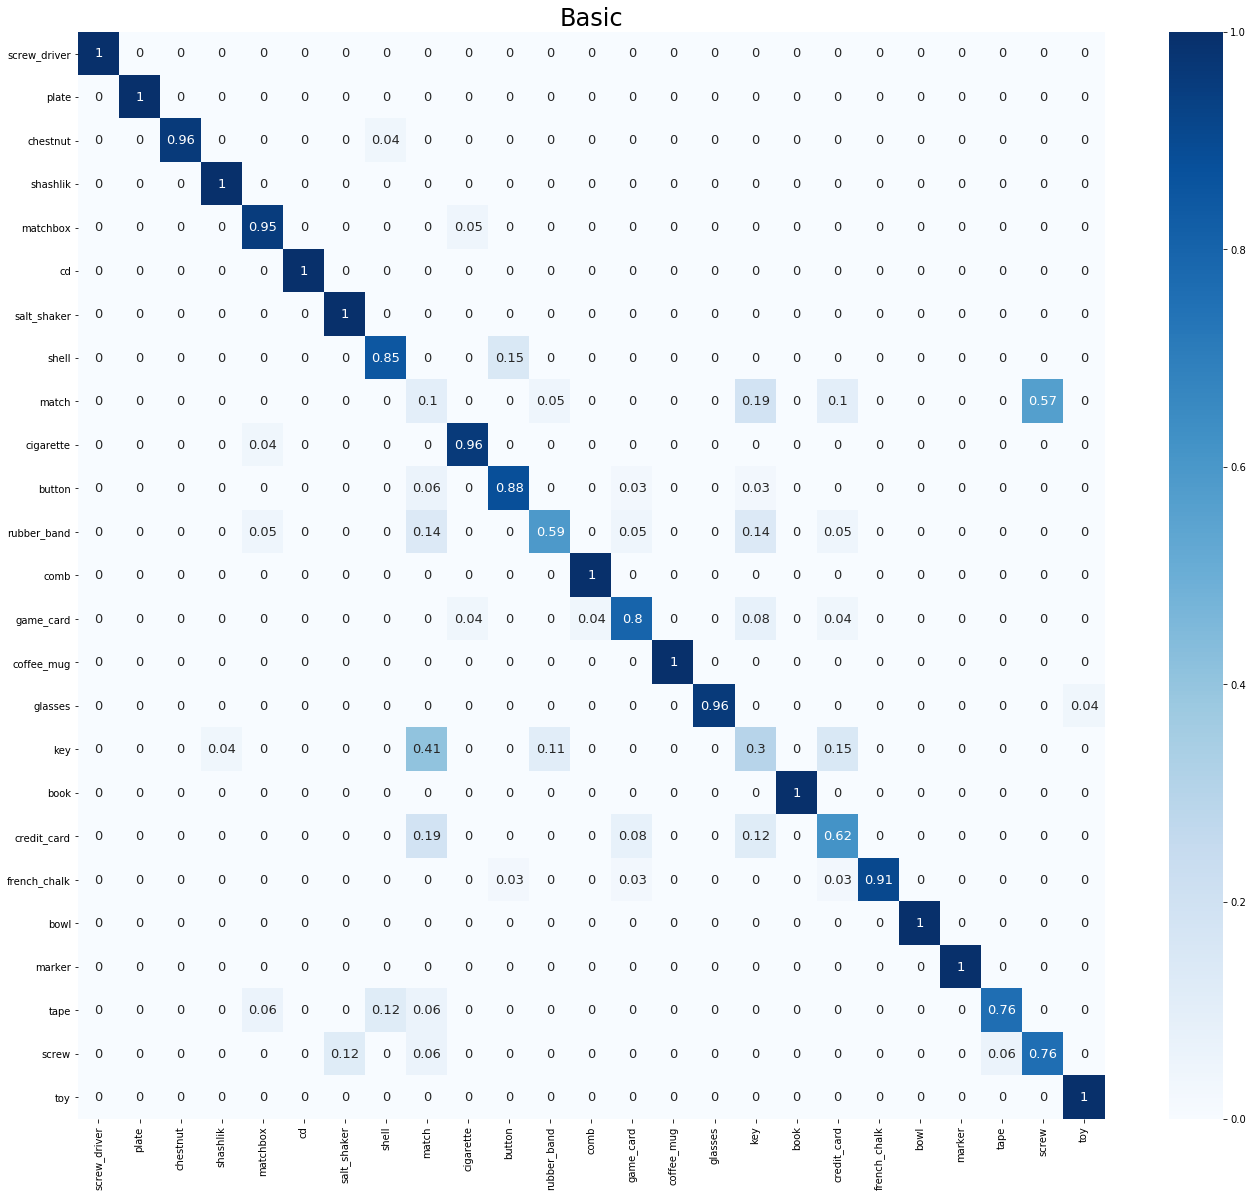

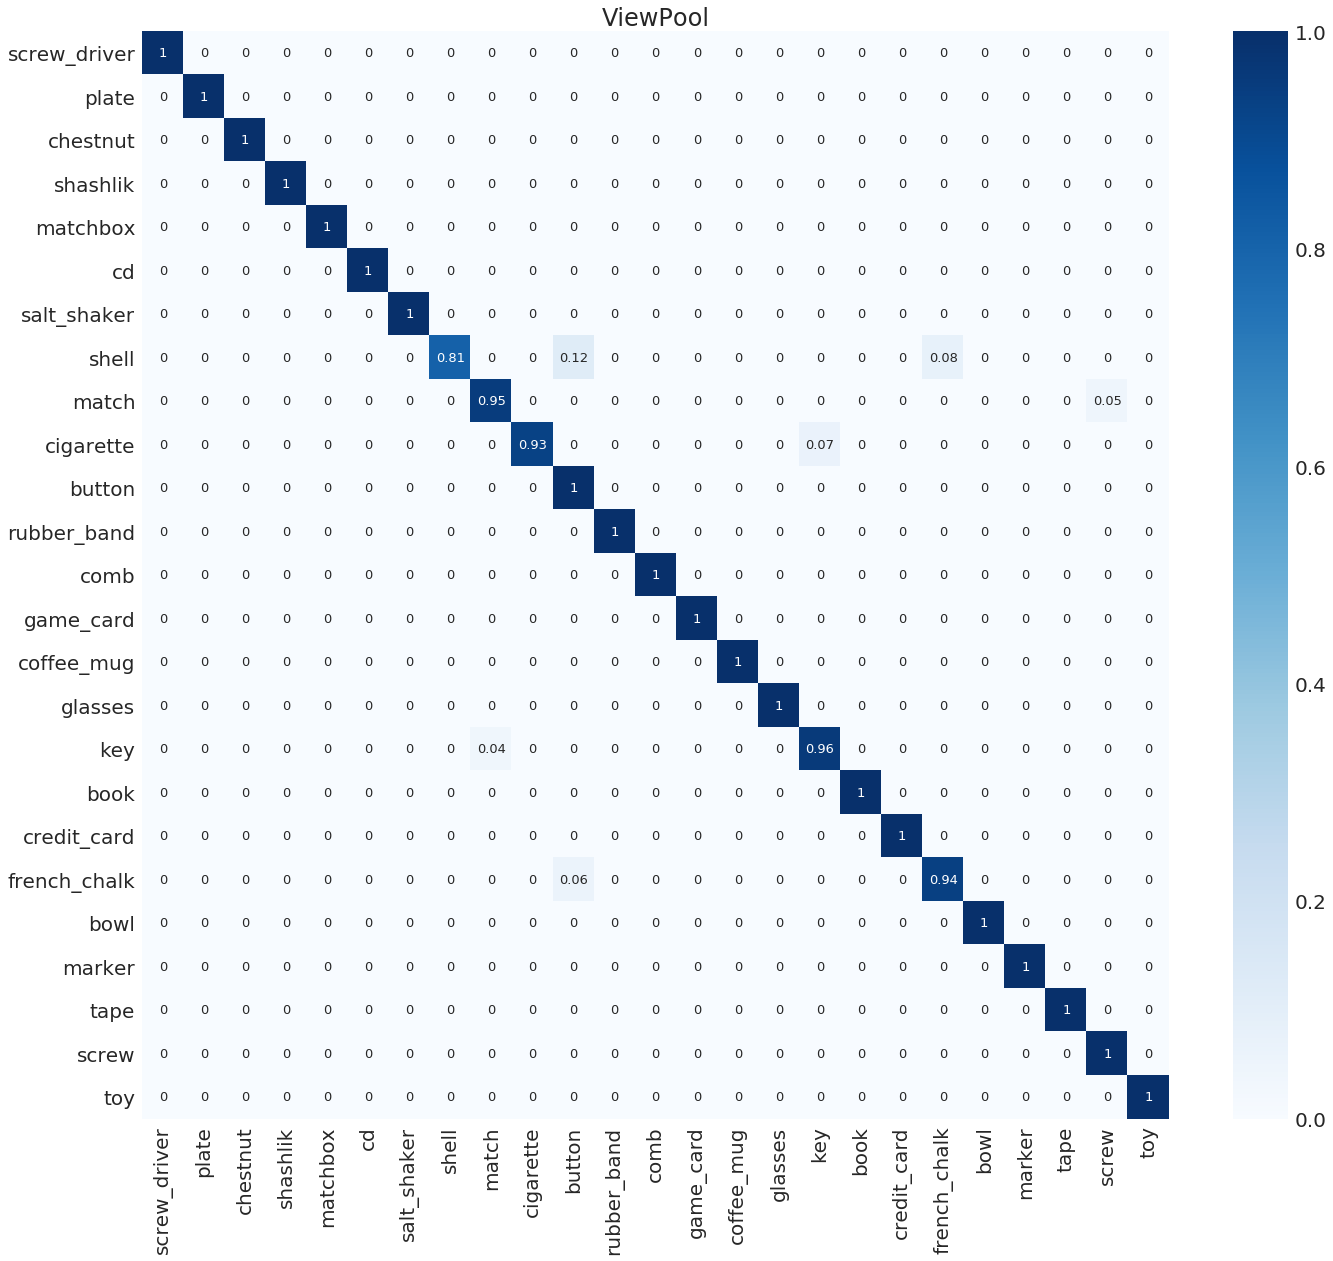

In [22]:
for model in models:
    plot_confusion(model,models)

In [146]:
def moving_avg(lista,N=3):
    cumsum, moving_aves = [0], []

    for i, x in enumerate(lista, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    return moving_aves

def analyze(models, phase, metric, N, save = False):
    
    logs = [(model_name,models[model_name]['log']) for model_name in models]

    for log_name, log_entry in logs:
        print("Plotting {}".format(log_name))
        entries = moving_avg([el for entry in log_entry[phase][metric] for el in entry],N=N)
        x = list(range(len(entries)))
        plt.plot(x,entries,label=log_name)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [ ]:
analyze(models=models,phase='valid',metric='acc',N=40)

In [44]:
def plot_obj_acc(model_name, models, save=False):
    obj_names = [display.translate_obj(el) for el in range(25)]
    obj_accs = []
    epoch = models[model_name]['log']['valid']['best_epoch']
    tot = models[model_name]['log']['valid']['confusion'][epoch].sum(axis = 1)
    for i in range(25):
        obj_accs.append(models[model_name]['log']['valid']['confusion'][epoch][i][i]/tot[i])

    obj_accs, obj_names = zip(*sorted(zip(obj_accs, obj_names),reverse=True))

    fig, ax = plt.subplots()

    index = np.arange(len(obj_names))
    bar_width = 0.4

    opacity = 0.4
    colors = ['r','g','b','y']
    
    ax.bar( index, obj_accs, width=bar_width,
            alpha=opacity, color='b',label= model_name )

    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy per object'+model_name)
    ax.set_xticks(index + bar_width/2)
    ax.set_xticklabels(obj_names,rotation = 90, ha="right")
    ax.legend()

    fig.tight_layout()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save==True:
        plt.savefig('/home/frati/Grasping/code/CNN/'+model_name+'.pdf',dpi=200)
    plt.show()

dict_keys(['best_epoch', 'epoch_loss', 'loss', 'epoch_acc', 'acc', 'obj_acc', 'confusion'])

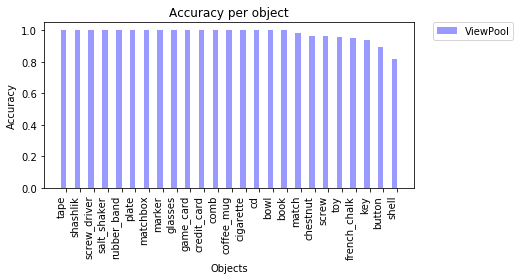

In [47]:
plot_obj_acc('ViewPool',models)

In [118]:
def compare_plot_obj_acc(master,slave, models):
    obj_names = np.array([display.translate_obj(el) for el in range(25)])
    obj_accs = {}
    
    for model in models:
        epoch = models[model]['log']['valid']['best_epoch']
        print(model,epoch)
        tot = models[model]['log']['valid']['confusion'][epoch].sum(axis = 1)
        for i in range(25):
            obj_accs.setdefault(model,np.empty(len(obj_names)))[i] = models[model]['log']['valid']['confusion'][epoch][i][i]/tot[i]
    sorting_indices = (-obj_accs[master]).argsort()
    obj_names = obj_names[sorting_indices]
    
    for model in obj_accs:
        obj_accs[model] = obj_accs[model][sorting_indices]
    
    fig, ax = plt.subplots()

    index = np.arange(len(obj_names))
    bar_width = 0.3
    spacing = 0.4
    opacity = 0.4
    
    ax.bar( index, obj_accs[master], width=bar_width,
            alpha=opacity, color='r',label=master )
    ax.bar( index + spacing, obj_accs[slave], width=bar_width,
            alpha=opacity, color='b',label=slave )


    ax.set_xlabel('Objects')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy per object')
    ax.set_xticks(index + (bar_width/2) + spacing)
    ax.set_xticklabels(obj_names,rotation = 90, ha="right")
    ax.legend()

    fig.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.savefig('test.pdf',dpi=200)
    plt.show()

ViewPool 3
Basic 2


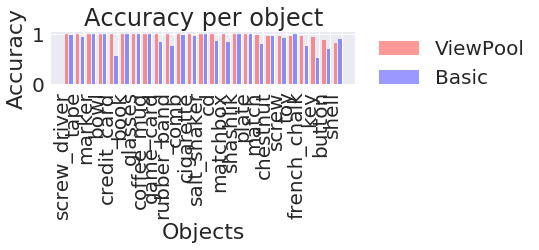

In [119]:
compare_plot_obj_acc('ViewPool','Basic',models)

In [140]:
for model in models:
    with open('/home/frati/Grasping/code/CNN/'+model+'_log.pkl','wb') as f:
        pickle.dump(models[model]['log'],f)

In [143]:
for model in models:
    state = {'best_acc':models[model]['best_acc'], 'state_dict':models[model]['model'].state_dict()}
    torch.save(state, '/home/frati/Grasping/code/CNN/'+model+'_model.pth.tar')

# Experiments

In [78]:
batch_criterion = nn.CrossEntropyLoss(reduce=False)
views, labels, lengths, targets = next(iter(loaders['train']))

inputs = varify(x=views,gpu_id=1)
ground_truth = varify(x=targets,gpu_id=1)

models['Basic']['model'].eval()
v_outputs = models['ViewPool']['model'].features_extractor[0](inputs[0])
#b_outputs = models['Basic'](sv_inputs)

#mv_loss = criterion(mv_out,mv_ground_truth)
#batch_loss = batch_criterion(mv_out,mv_ground_truth)
#sv_losses = criterion(sv_out,sv_ground_truth)

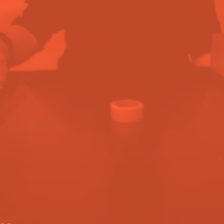

In [172]:
a = v_outputs[5].detach().cpu().data
a /= a.max()
#a *= 255
display.plot_tensor(a)

In [46]:
_, mv_preds = torch.max(mv_out,1)
mv_acc = float(torch.sum(mv_preds == mv_ground_truth))/len(mv_preds)
mv_acc

0.75

In [49]:
_, sv_preds = torch.max(sv_out,1)
#sv_preds[0][0] = sv_ground_truth[0]
sv_acc = float(sum(torch.sum(sv_preds == sv_ground_truth))) / len(sv_preds)
sv_acc

0.875

In [51]:
for a,b in zip((mv_preds == mv_ground_truth).data,targets):
    print(a,b)

1 3
0 19
0 19
1 0
1 23
1 0
1 21
1 24


In [21]:
class Ensembler(nn.Module):
    def __init__(self, embed_size, features_extractor, num_features, views):
        super(Ensembler, self).__init__()
        self.features_extractor = features_extractor
        self.ensemble = nn.MaxPool2d(kernel_size=(views,1))
        self.linear = nn.Linear(num_features, embed_size)

    def forward(self, views):
        views_features = [self.features_extractor(view) for view in views]
        batch,filter,h,w = views_features[0].shape
        outs = [ self.linear(el.view(batch,-1)) for el in views_features ]
        stacked_outs = torch.stack(outs,dim=1)
        out = self.ensemble(stacked_outs)
        return out.squeeze(),stacked_outs
    
ensemble = Ensembler( embed_size=25, features_extractor=single_features_extractor, num_features=512*14*14, views=4 )
ensemble.cuda(0)
#multiview_trainable_params = get_trainable_parameters(multiview_model)

Ensembler(
  (features_extractor): Sequential(
    (0): ColorNet(
      (conv1): Conv2d(1, 10, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
      (conv2_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): partialVGG(
      (features): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [22]:
ensemble

Ensembler(
  (features_extractor): Sequential(
    (0): ColorNet(
      (conv1): Conv2d(1, 10, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
      (conv2_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): partialVGG(
      (features): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [18]:
colored_views = [colorer(view) for view in mv_inputs]

In [19]:
colored_views[0].shape

torch.Size([16, 3, 224, 224])

In [20]:
features_views = [multidepth_vgg(view) for view in colored_views]

torch.Size([16, 512, 7, 7])
torch.Size([16, 1536, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 1536, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 1536, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 1536, 7, 7])
torch.Size([16, 512, 7, 7])
torch.Size([16, 512, 7, 7])


In [21]:
features_views[0].shape

torch.Size([16, 512, 7, 7])

In [185]:
def variable_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
def get_tensor(var):
    return var.detach().cpu().data

def as_image(tensor):
    return torch.stack([tensor]*3)

def normalize(tensor):
    return tensor / tensor.max()

In [315]:
features_views[0].shape

torch.Size([16, 512, 14, 14])

In [339]:
tensor_features = [get_tensor(view[0][0]) for view in features_views]

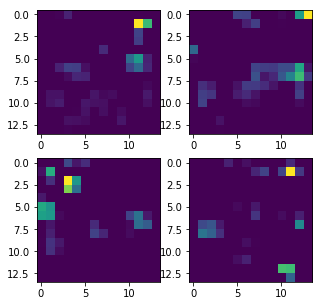

In [340]:
fig=plt.figure(figsize=(5, 5))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = tensor_features[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

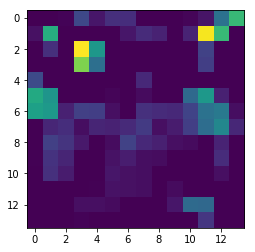

In [341]:
max_view = np.array([view.numpy() for view in tensor_features]).max(axis=0)
#max_view /= max_view.max()
plt.imshow(max_view)

In [336]:
def view_pool(views_features):
    ims,filters,h,w = views_features[0].shape
    flat_views = [view.view(ims,-1) for view in views_features]
    stacked_views = torch.stack(flat_views,dim=1)
    pooled_views = nn.MaxPool2d(kernel_size=(4,1),stride=1)(stacked_views).squeeze()
    return pooled_views

def view_pool0(views):
        
    batch,filters,h,w = views[0].shape
    combined_views = torch.stack(views,dim=2).view(batch,-1,h,w)
    print("Combined {}".format(combined_views.shape))
    features = nn.MaxPool3d((4,1,1), stride=(4,1,1))(combined_views)
    features = features.view(batch,-1)
    return features,combined_views

In [347]:
a = view_pool(features_views)

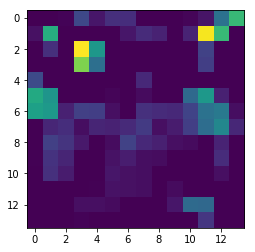

In [348]:
my_pool = a[0].view(512,14,14)[0].detach().cpu().numpy()
plt.imshow(my_pool)

In [303]:
(my_pool - max_view).sum()

0.0

In [351]:
v0, c0 = view_pool0(features_views)
v0.shape

Combined torch.Size([16, 2048, 14, 14])


torch.Size([16, 100352])

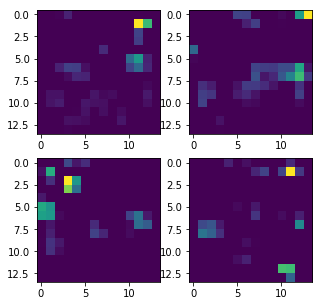

In [352]:
test = c0[0][0:4].detach().cpu().numpy()
fig=plt.figure(figsize=(5, 5))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = test[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

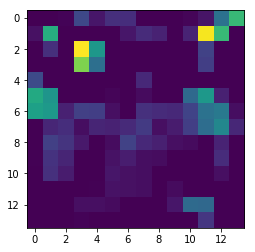

In [353]:
plt.imshow(test.max(axis=0))

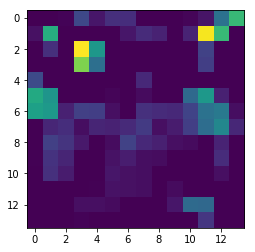

In [356]:
plt.imshow(v0.view(16,512,14,14)[0][0].detach().cpu().numpy())

### MultiDepth (LEAP)

In [17]:
# multidepth_vgg = get_multidepthVGG()
# multidepth_features = 512*7*7 # used to construct the fully connected layer

# for param in multidepth_vgg.features.parameters(): # freeze vgg
#     param.requires_grad = False
    
# leap_features_extractor = nn.Sequential( ColorNet(pretrained='/home/frati/Grasping/code/data/colorer_model/model_best_acc52.pth.tar'),
#                                          multidepth_vgg)

# leap_ensemble_model = Ensembler( features_extractor=leap_features_extractor,
#                                  in_features=multidepth_features,
#                                  out_features=25,
#                                  views=4)

# leap_ensemble_trainable_params = get_trainable_parameters(leap_ensemble_model)


# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(leap_ensemble_trainable_params, lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# models['MultiDepth'] = {
#     'model': leap_ensemble_model,
#     'criterion': criterion,
#     'optimizer': optimizer,
#     'scheduler': scheduler
# }

# leap_ensemble_model

### MultiDepthViewPooling

In [18]:
# multidepth_vgg = get_multidepthVGG()
# multidepth_features = 512*7*7 # used to construct the fully connected layer

# for param in multidepth_vgg.features.parameters(): # freeze vgg
#     param.requires_grad = False

# leap_features_extractor = nn.Sequential( ColorNet(pretrained='/home/frati/Grasping/code/data/colorer_model/model_best_acc52.pth.tar'),
#                                          multidepth_vgg )

# mdvp_model = ViewPooler( features_extractor=leap_features_extractor, 
#                          num_features=multidepth_features,
#                          embed_size=25,
#                          views=4 )

# mdvp_trainable_params = get_trainable_parameters(mdvp_model)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(mdvp_trainable_params, lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# models['MDVP'] = {
#     'model': mdvp_model,
#     'criterion': criterion,
#     'optimizer': optimizer,
#     'scheduler': scheduler
# }

# mdvp_model